----
<div align="center">
  <h2><strong><em>CSC417: Machine Intelligence Project</em></strong></h2>
</div>

----

<div style="border: 1px solid #ddd; border-radius: 8px; padding: 16px; width: 350px; font-family: sans-serif; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
  <p style="margin: 0 0 8px 0;">
    <strong>Name:</strong> 
    <em style="color: #c9302c; font-weight: bold;">Ammar Tarek Khattab</em>
  </p>
  <p style="margin: 0;">
    <strong>ID:</strong> 
    <em style="color: #c9302c; font-weight: bold;">202002123</em>
  </p>
</div>

<font size="4" color="#6495ED">***1. Import Libraries:***</font>

In [31]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import time
from datetime import datetime
warnings.filterwarnings('ignore')

# Import all models from the course
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    f1_score, precision_score, recall_score, roc_auc_score
)

# Course Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

# Additional powerful models
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier

# For handling imbalanced data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

print("✅ All libraries imported!")
print(f"Execution started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All libraries imported!
Execution started at: 2025-08-09 03:01:50


<font size="4" color="#6495ED">***2. Load Dataset:***</font>

In [32]:
# Cell 2: Load Engineered Data
df = pd.read_csv('../data/processed/pirvision_engineered.csv')
print(f"\n📊 Dataset shape: {df.shape}")

# Remove datetime columns if present
datetime_cols = ['Date', 'Time', 'DateTime', 'Minute', 'Second']
feature_cols = [col for col in df.columns if col not in datetime_cols + ['Label']]

X = df[feature_cols]
y = df['Label']

print(f"✅ Features: {X.shape[1]}")
print(f"✅ Samples: {X.shape[0]}")
print(f"\n🎯 Target distribution:")
print(y.value_counts().sort_index())
print(f"\nClass percentages:")
for cls in sorted(y.unique()):
    print(f"  Class {cls}: {(y==cls).sum()/len(y)*100:.1f}%")


📊 Dataset shape: (7651, 106)
✅ Features: 102
✅ Samples: 7651

🎯 Target distribution:
Label
0    6247
1     833
3     571
Name: count, dtype: int64

Class percentages:
  Class 0: 81.6%
  Class 1: 10.9%
  Class 3: 7.5%


<font size="4" color="#6495ED">***3. Data Split - Train / Test***</font>

In [33]:
# Cell 3: Train-Test Split with Stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📊 Train set: {X_train.shape}")
print(f"📊 Test set: {X_test.shape}")
print(f"\nTrain distribution:\n{y_train.value_counts().sort_index()}")
print(f"\nTest distribution:\n{y_test.value_counts().sort_index()}")


📊 Train set: (6120, 102)
📊 Test set: (1531, 102)

Train distribution:
Label
0    4997
1     666
3     457
Name: count, dtype: int64

Test distribution:
Label
0    1250
1     167
3     114
Name: count, dtype: int64


<font size="4" color="#6495ED">***4. Handle Class Imbalance:***</font>

In [34]:
from collections import Counter

print("\n⚖️ Handling Class Imbalance...")
print(f"Original distribution: {Counter(y_train)}")

# Apply SMOTE-Tomek for better balance
smote_tomek = SMOTETomek(random_state=42)
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train, y_train)

print(f"Balanced distribution: {Counter(y_train_balanced)}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Data preprocessing complete!")
print(f"  Training samples: {len(X_train_scaled)}")
print(f"  Testing samples: {len(X_test_scaled)}")


⚖️ Handling Class Imbalance...
Original distribution: Counter({0: 4997, 1: 666, 3: 457})
Balanced distribution: Counter({0: 4487, 1: 4302, 3: 4094})

✅ Data preprocessing complete!
  Training samples: 12883
  Testing samples: 1531


<font size="4" color="#6495ED">***5. Initialize All Models :***</font>

In [35]:
models = {
    # LECTURE 2: Linear Models
    '01_Logistic_Regression': LogisticRegression(
        max_iter=1000, 
        multi_class='multinomial',
        solver='lbfgs',
        random_state=42
    ),
    
    # Non-parametric Models ( KNN & Decision Trees )
    '02_KNN': KNeighborsClassifier(
        n_neighbors=7,
        weights='distance',
        metric='minkowski'
    ),
    
    '03_Decision_Tree': DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    ),
    
    # Support Vector Machines
    '04_SVM_Linear': SVC(
        kernel='linear',
        probability=True,
        random_state=42
    ),
    
    '05_SVM_RBF': SVC(
        kernel='rbf',
        gamma='scale',
        probability=True,
        random_state=42
    ),
    
    # ENSEMBLE METHODS (Extension of Decision Trees)
    '06_Random_Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    ),
    
    '07_Extra_Trees': ExtraTreesClassifier(
        n_estimators=200,
        max_depth=15,
        random_state=42,
        n_jobs=-1
    ),
    
    # Neural Networks
    '08_Neural_Network': MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        solver='adam',
        max_iter=500,
        early_stopping=True,
        random_state=42
    ),
    
    # BOOSTING METHODS
    '09_XGBoost': xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss'
    ),
    
    '10_AdaBoost': AdaBoostClassifier(
        n_estimators=100,
        learning_rate=1.0,
        algorithm='SAMME',
        random_state=42
    ),
    
    '11_Gradient_Boosting': GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        random_state=42
    ),
    
    # ADDITIONAL: Naive Bayes (for comparison)
    '12_Naive_Bayes': GaussianNB()
}

print(f"\n🤖 Initialized {len(models)} models for training")


🤖 Initialized 12 models for training


In [36]:
# Cell 4.5: Fix Class Labels for XGBoost
from sklearn.preprocessing import LabelEncoder

# Create label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels
y_train_encoded = label_encoder.fit_transform(y_train_balanced)
y_test_encoded = label_encoder.transform(y_test)

# Store original class mapping
class_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}
print(f"Class mapping: {class_mapping}")
print(f"Original classes: {np.unique(y_train_balanced)}")
print(f"Encoded classes: {np.unique(y_train_encoded)}")

# Use encoded labels for training
y_train_final = y_train_encoded
y_test_final = y_test_encoded

Class mapping: {0: 0, 1: 1, 2: 3}
Original classes: [0 1 3]
Encoded classes: [0 1 2]


<font size="4" color="#6495ED">***6. Train and Evaluate All Models:***</font>

In [37]:
# Cell 6: Train and Evaluate All Models (UPDATED)
results = {}
training_times = {}

print("\n" + "="*60)
print("TRAINING ALL MODELS")
print("="*60)

for name, model in models.items():
    print(f"\n📊 Training {name.replace('_', ' ')}...")
    
    # Start timer
    start_time = time.time()
    
    try:
        # Use encoded labels for all models
        model.fit(X_train_scaled, y_train_final)  # Changed from y_train_balanced
        
        # Time taken
        train_time = time.time() - start_time
        training_times[name] = train_time
        
        # Predict
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = None
        
        # For metrics, we need to decode back to original labels
        y_test_original = label_encoder.inverse_transform(y_test_final)
        y_pred_original = label_encoder.inverse_transform(y_pred)
        
        # Calculate metrics using original labels
        accuracy = accuracy_score(y_test_original, y_pred_original)
        precision = precision_score(y_test_original, y_pred_original, average='weighted')
        recall = recall_score(y_test_original, y_pred_original, average='weighted')
        f1 = f1_score(y_test_original, y_pred_original, average='weighted')
        
        # Cross-validation
        cv_scores = cross_val_score(
            model, X_train_scaled, y_train_final,  # Use encoded labels
            cv=3, scoring='f1_weighted', n_jobs=-1
        )
        
        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'train_time': train_time,
            'predictions': y_pred_original,  # Store original labels
            'model': model
        }
        
        print(f"  ✅ Accuracy: {accuracy:.4f}")
        print(f"  ✅ F1-Score: {f1:.4f}")
        print(f"  ✅ CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
        print(f"  ⏱️ Training time: {train_time:.2f}s")
        
    except Exception as e:
        print(f"  ❌ Error training {name}: {str(e)}")
        continue


TRAINING ALL MODELS

📊 Training 01 Logistic Regression...
  ✅ Accuracy: 0.9811
  ✅ F1-Score: 0.9814
  ✅ CV F1: 0.9901 (+/- 0.0034)
  ⏱️ Training time: 0.81s

📊 Training 02 KNN...
  ✅ Accuracy: 0.9693
  ✅ F1-Score: 0.9703
  ✅ CV F1: 0.9915 (+/- 0.0003)
  ⏱️ Training time: 0.01s

📊 Training 03 Decision Tree...
  ✅ Accuracy: 0.9895
  ✅ F1-Score: 0.9896
  ✅ CV F1: 0.9916 (+/- 0.0043)
  ⏱️ Training time: 1.28s

📊 Training 04 SVM Linear...
  ✅ Accuracy: 0.9909
  ✅ F1-Score: 0.9909
  ✅ CV F1: 0.9961 (+/- 0.0014)
  ⏱️ Training time: 3.14s

📊 Training 05 SVM RBF...
  ✅ Accuracy: 0.9824
  ✅ F1-Score: 0.9827
  ✅ CV F1: 0.9930 (+/- 0.0018)
  ⏱️ Training time: 8.67s

📊 Training 06 Random Forest...
  ✅ Accuracy: 0.9882
  ✅ F1-Score: 0.9884
  ✅ CV F1: 0.9954 (+/- 0.0012)
  ⏱️ Training time: 5.90s

📊 Training 07 Extra Trees...
  ✅ Accuracy: 0.9889
  ✅ F1-Score: 0.9890
  ✅ CV F1: 0.9961 (+/- 0.0009)
  ⏱️ Training time: 0.96s

📊 Training 08 Neural Network...
  ✅ Accuracy: 0.9889
  ✅ F1-Score: 0.9890
  

<font size="4" color="#6495ED">***7. Create Ensemble Model (Voting Classifier):***</font>

In [38]:
print("\n" + "="*60)
print("CREATING ENSEMBLE MODEL")
print("="*60)

# Select top 3 models based on F1-score
sorted_models = sorted(results.items(), key=lambda x: x[1]['f1_score'], reverse=True)
top_3_models = sorted_models[:3]

print("\nTop 3 models for ensemble:")
for name, metrics in top_3_models:
    print(f"  • {name.replace('_', ' ')}: F1={metrics['f1_score']:.4f}")

# Create ensemble
ensemble_models = [(name, results[name]['model']) for name, _ in top_3_models]
voting_clf = VotingClassifier(
    estimators=ensemble_models,
    voting='soft'
)

# Train ensemble
print("\n🎯 Training Ensemble Model...")
start_time = time.time()
voting_clf.fit(X_train_scaled, y_train_balanced)
ensemble_time = time.time() - start_time

# Evaluate ensemble
y_pred_ensemble = voting_clf.predict(X_test_scaled)
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
ensemble_f1 = f1_score(y_test, y_pred_ensemble, average='weighted')

print(f"  ✅ Ensemble Accuracy: {ensemble_accuracy:.4f}")
print(f"  ✅ Ensemble F1-Score: {ensemble_f1:.4f}")
print(f"  ⏱️ Training time: {ensemble_time:.2f}s")

results['13_Ensemble_Voting'] = {
    'accuracy': ensemble_accuracy,
    'precision': precision_score(y_test, y_pred_ensemble, average='weighted'),
    'recall': recall_score(y_test, y_pred_ensemble, average='weighted'),
    'f1_score': ensemble_f1,
    'train_time': ensemble_time,
    'predictions': y_pred_ensemble,
    'model': voting_clf
}


CREATING ENSEMBLE MODEL

Top 3 models for ensemble:
  • 11 Gradient Boosting: F1=0.9935
  • 09 XGBoost: F1=0.9922
  • 04 SVM Linear: F1=0.9909

🎯 Training Ensemble Model...
  ✅ Ensemble Accuracy: 0.9928
  ✅ Ensemble F1-Score: 0.9929
  ⏱️ Training time: 421.54s


<font size="4" color="#6495ED">***8. Results Summary and Comparison:***</font>

In [39]:
import pandas as pd

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': [name.replace('_', ' ') for name in results.keys()],
    'Accuracy': [r['accuracy'] for r in results.values()],
    'Precision': [r['precision'] for r in results.values()],
    'Recall': [r['recall'] for r in results.values()],
    'F1-Score': [r['f1_score'] for r in results.values()],
    'CV Mean': [r.get('cv_mean', 0) for r in results.values()],
    'Train Time (s)': [r['train_time'] for r in results.values()]
}).sort_values('F1-Score', ascending=False)

print("\n" + "="*60)
print("MODEL COMPARISON RESULTS")
print("="*60)
print(comparison_df.to_string(index=False))

# Save results
comparison_df.to_csv('../data/processed/model_comparison_results.csv', index=False)
print(f"\n💾 Results saved to: ../data/processed/model_comparison_results.csv")



MODEL COMPARISON RESULTS
                 Model  Accuracy  Precision   Recall  F1-Score  CV Mean  Train Time (s)
  11 Gradient Boosting  0.993468   0.993608 0.993468  0.993504 0.997127      406.798419
    13 Ensemble Voting  0.992815   0.992992 0.992815  0.992860 0.000000      421.543690
            09 XGBoost  0.992162   0.992347 0.992162  0.992214 0.997205        3.641741
         04 SVM Linear  0.990856   0.991173 0.990856  0.990932 0.996120        3.144307
      03 Decision Tree  0.989549   0.989669 0.989549  0.989583 0.991623        1.275700
        07 Extra Trees  0.988896   0.989353 0.988896  0.989011 0.996118        0.964077
     08 Neural Network  0.988896   0.989117 0.988896  0.988960 0.996894        2.416825
      06 Random Forest  0.988243   0.988693 0.988243  0.988355 0.995419        5.898553
           10 AdaBoost  0.987590   0.988070 0.987590  0.987724 0.988829       22.596805
            05 SVM RBF  0.982364   0.983682 0.982364  0.982675 0.993011        8.671157
01 Log

<font size="4" color="#6495ED">***9. Visualize Model Comparison:***</font>

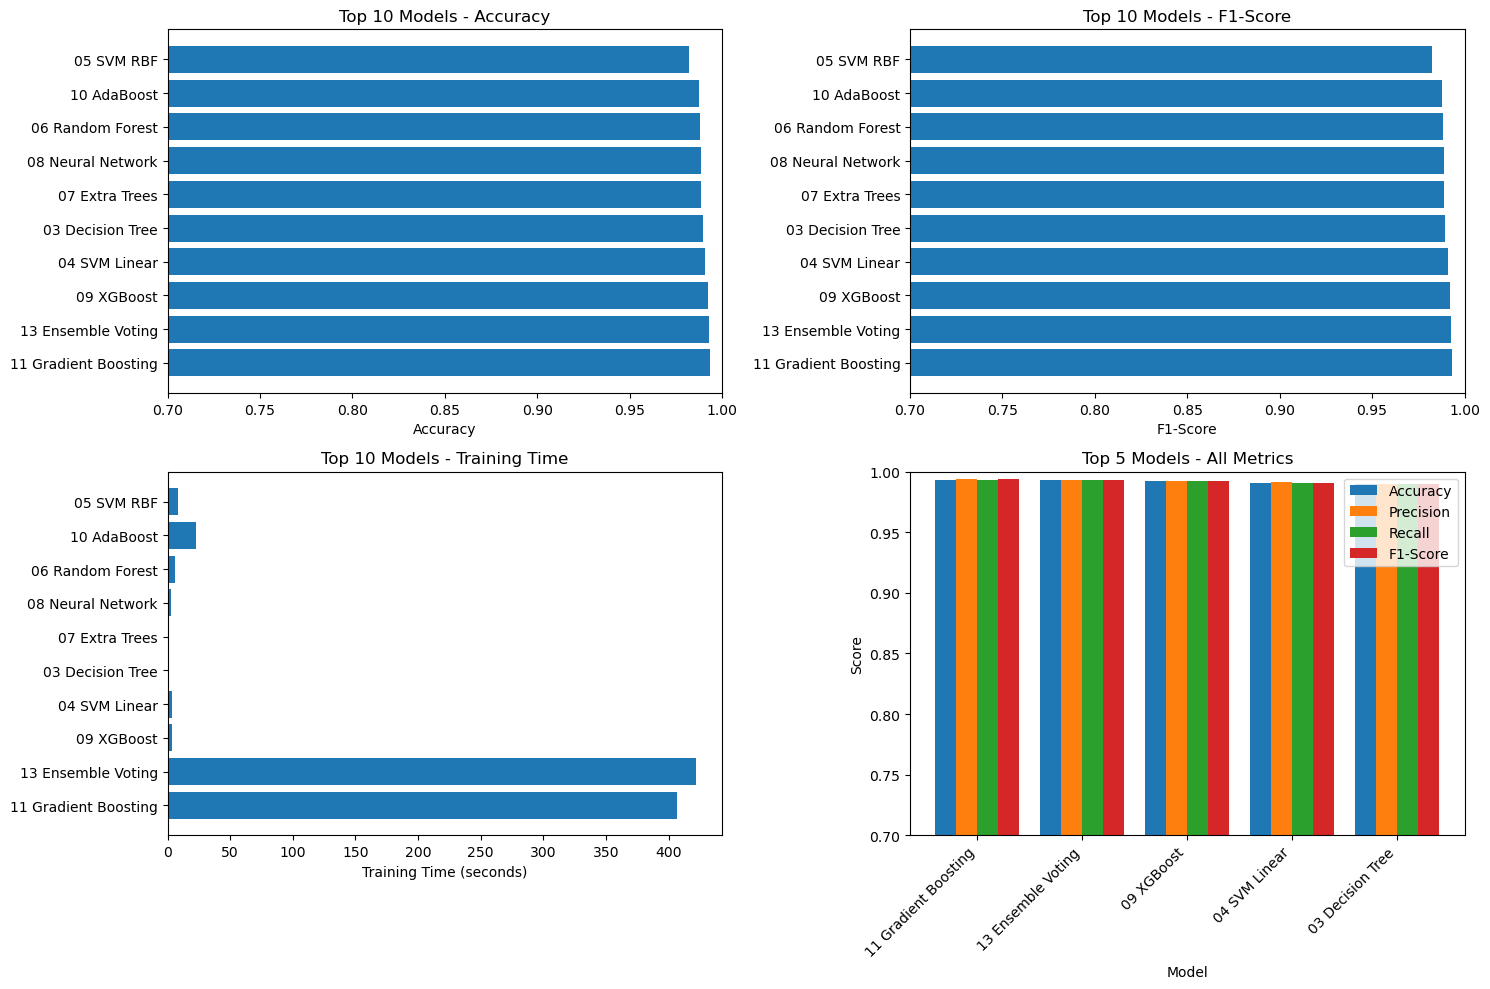

📊 Visualizations saved to: ../reports/model_comparison.png


In [40]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Accuracy comparison
axes[0, 0].barh(comparison_df['Model'][:10], comparison_df['Accuracy'][:10])
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Top 10 Models - Accuracy')
axes[0, 0].set_xlim([0.7, 1.0])

# 2. F1-Score comparison
axes[0, 1].barh(comparison_df['Model'][:10], comparison_df['F1-Score'][:10])
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('Top 10 Models - F1-Score')
axes[0, 1].set_xlim([0.7, 1.0])

# 3. Training time comparison
axes[1, 0].barh(comparison_df['Model'][:10], comparison_df['Train Time (s)'][:10])
axes[1, 0].set_xlabel('Training Time (seconds)')
axes[1, 0].set_title('Top 10 Models - Training Time')

# 4. Metrics comparison for top 5
top_5 = comparison_df.head(5)
x = np.arange(len(top_5))
width = 0.2

axes[1, 1].bar(x - width*1.5, top_5['Accuracy'], width, label='Accuracy')
axes[1, 1].bar(x - width/2, top_5['Precision'], width, label='Precision')
axes[1, 1].bar(x + width/2, top_5['Recall'], width, label='Recall')
axes[1, 1].bar(x + width*1.5, top_5['F1-Score'], width, label='F1-Score')

axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Top 5 Models - All Metrics')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(top_5['Model'], rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].set_ylim([0.7, 1.0])

plt.tight_layout()
plt.savefig('../reports/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Visualizations saved to: ../reports/model_comparison.png")

<font size="4" color="#6495ED">***10. Best Model Detailed Analysis:***</font>


BEST MODEL: 11 Gradient Boosting
Accuracy: 0.9935
F1-Score: 0.9935

📋 Classification Report:
              precision    recall  f1-score   support

     Vacancy     0.9992    0.9936    0.9964      1250
  Stationary     0.9708    0.9940    0.9822       167
    Activity     0.9658    0.9912    0.9784       114

    accuracy                         0.9935      1531
   macro avg     0.9786    0.9929    0.9857      1531
weighted avg     0.9936    0.9935    0.9935      1531



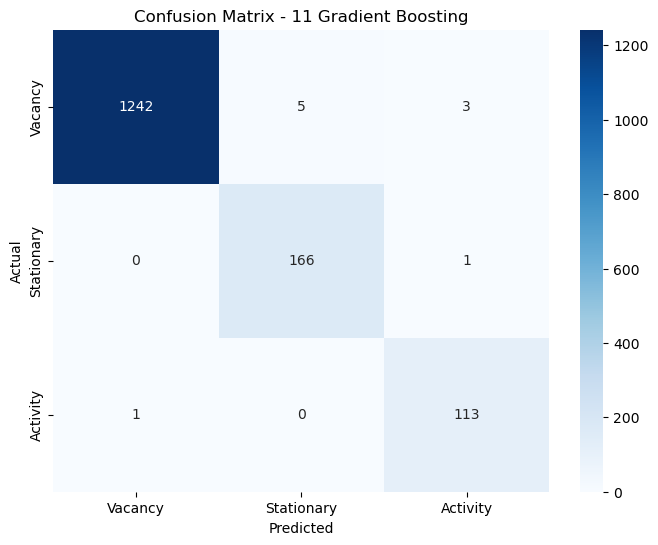


💾 Confusion matrix saved to: ../reports/best_model_confusion_matrix.png


In [41]:
best_model_name = comparison_df.iloc[0]['Model'].replace(' ', '_')
best_model_key = [k for k in results.keys() if k.replace('_', ' ') == comparison_df.iloc[0]['Model']][0]
best_model = results[best_model_key]['model']
best_predictions = results[best_model_key]['predictions']

print(f"\n" + "="*60)
print(f"BEST MODEL: {comparison_df.iloc[0]['Model']}")
print("="*60)
print(f"Accuracy: {comparison_df.iloc[0]['Accuracy']:.4f}")
print(f"F1-Score: {comparison_df.iloc[0]['F1-Score']:.4f}")

# Classification report
print("\n📋 Classification Report:")
print(classification_report(y_test, best_predictions, 
                           target_names=['Vacancy', 'Stationary', 'Activity'],
                           digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, best_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Vacancy', 'Stationary', 'Activity'],
            yticklabels=['Vacancy', 'Stationary', 'Activity'])
plt.title(f'Confusion Matrix - {comparison_df.iloc[0]["Model"]}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('../reports/best_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💾 Confusion matrix saved to: ../reports/best_model_confusion_matrix.png")

<font size="4" color="#6495ED">***11. Feature Importance Analysis (for tree-based models):***</font>

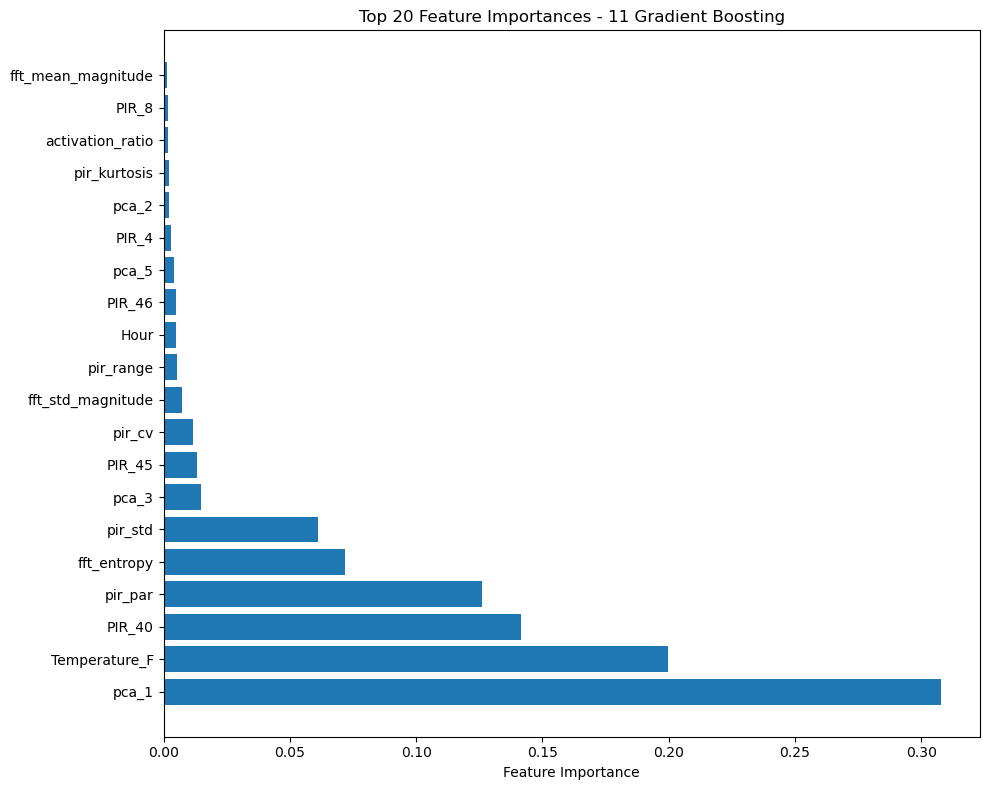


🎯 Top 10 Most Important Features:
          feature  importance
            pca_1    0.307864
    Temperature_F    0.199562
           PIR_40    0.141550
          pir_par    0.126122
      fft_entropy    0.071766
          pir_std    0.060993
            pca_3    0.014890
           PIR_45    0.013140
           pir_cv    0.011614
fft_std_magnitude    0.007289

💾 Feature importances saved to: ../data/processed/feature_importances.csv


In [42]:
# Check if best model has feature importance
if hasattr(best_model, 'feature_importances_'):
    importances = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(10, 8))
    top_20 = importances.head(20)
    plt.barh(range(len(top_20)), top_20['importance'])
    plt.yticks(range(len(top_20)), top_20['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 20 Feature Importances - {comparison_df.iloc[0]["Model"]}')
    plt.tight_layout()
    plt.savefig('../reports/feature_importances.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n🎯 Top 10 Most Important Features:")
    print(importances.head(10).to_string(index=False))
    
    # Save feature importances
    importances.to_csv('../data/processed/feature_importances.csv', index=False)
    print(f"\n💾 Feature importances saved to: ../data/processed/feature_importances.csv")

<font size="4" color="#6495ED">***12. Save Final Models:***</font>

In [43]:
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save best model
best_model_filename = f"best_model_{best_model_key.lower()}.pkl"
joblib.dump(best_model, f'../models/{best_model_filename}')
print(f"\n✅ Best model saved to: ../models/{best_model_filename}")

# Save scaler
joblib.dump(scaler, '../models/scaler.pkl')
print(f"✅ Scaler saved to: ../models/scaler.pkl")

# Save top 3 models
for name, metrics in top_3_models:
    model = results[name]['model']
    filename = f"model_{name.lower()}.pkl"
    joblib.dump(model, f'../models/{filename}')
    print(f"✅ {name} saved to: ../models/{filename}")

# Save ensemble model
joblib.dump(voting_clf, '../models/ensemble_voting_classifier.pkl')
print(f"✅ Ensemble model saved to: ../models/ensemble_voting_classifier.pkl")



✅ Best model saved to: ../models/best_model_11_gradient_boosting.pkl
✅ Scaler saved to: ../models/scaler.pkl
✅ 11_Gradient_Boosting saved to: ../models/model_11_gradient_boosting.pkl
✅ 09_XGBoost saved to: ../models/model_09_xgboost.pkl
✅ 04_SVM_Linear saved to: ../models/model_04_svm_linear.pkl
✅ Ensemble model saved to: ../models/ensemble_voting_classifier.pkl


<font size="4" color="#6495ED">***13. Final Summary:***</font>

In [44]:
print("\n" + "="*60)
print("PROJECT SUMMARY")
print("="*60)
print(f"✅ Models trained: {len(results)}")
print(f"✅ Best model: {comparison_df.iloc[0]['Model']}")
print(f"✅ Best accuracy: {comparison_df.iloc[0]['Accuracy']:.4f}")
print(f"✅ Best F1-score: {comparison_df.iloc[0]['F1-Score']:.4f}")
print(f"✅ Total training time: {sum([r['train_time'] for r in results.values()]):.2f}s")
print(f"\n📁 All models and results saved successfully!")
print(f"🎯 Ready for report generation!")


PROJECT SUMMARY
✅ Models trained: 13
✅ Best model: 11 Gradient Boosting
✅ Best accuracy: 0.9935
✅ Best F1-score: 0.9935
✅ Total training time: 877.80s

📁 All models and results saved successfully!
🎯 Ready for report generation!
